In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stimulations = pd.read_csv('../../data/sim1/vns_stimulations.csv')
responses = pd.read_csv('../../data/sim1/vns_responses.csv')

t_stim = stimulations['time'].values
t_resp = responses['time'].values

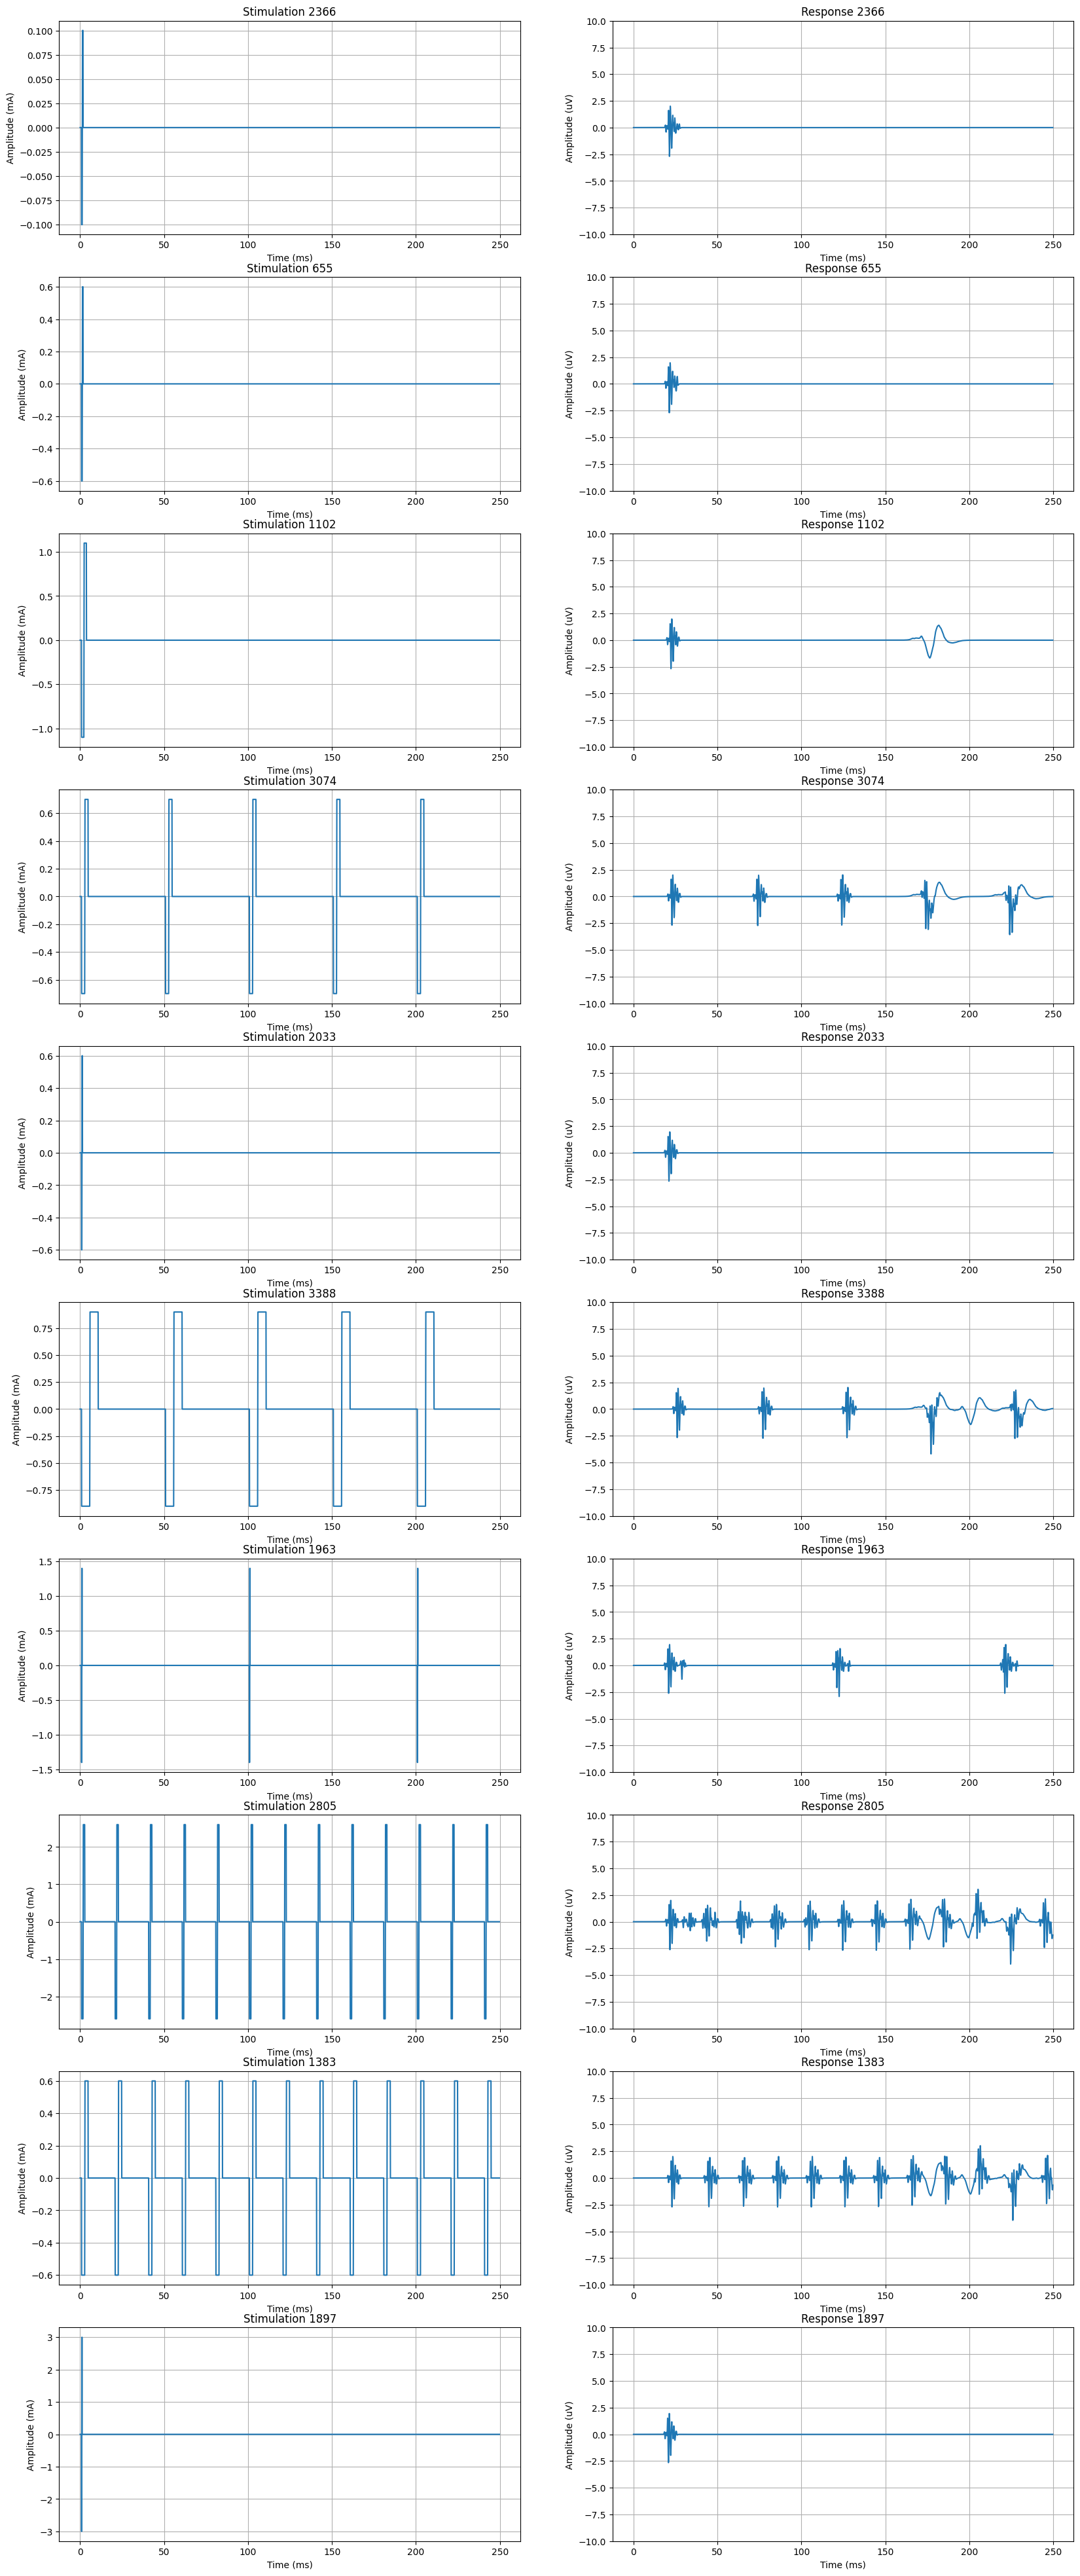

In [2]:
random_id = np.random.randint(0, len(stimulations.columns)-1, 10)

fig, ax = plt.subplots(10, 2, figsize=(20, 50))
for i, id in enumerate(random_id):
    ax[i, 0].plot(t_stim, -stimulations[str(id)].values)
    ax[i, 0].set_title('Stimulation {}'.format(id))
    ax[i, 0].set_xlabel('Time (ms)')
    ax[i, 0].set_ylabel('Amplitude (mA)')
    ax[i, 0].grid(True)

    ax[i, 1].plot(t_resp, responses[str(id)].values)
    ax[i, 1].set_title('Response {}'.format(id))
    ax[i, 1].set_xlabel('Time (ms)')
    ax[i, 1].set_ylabel('Amplitude (uV)')
    ax[i, 1].set_ylim(-10, 10)
    ax[i, 1].grid(True)

In [3]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

stimulations = pd.read_csv('../../data/sim1/vns_stimulations.csv')
responses = pd.read_csv('../../data/sim1/vns_responses.csv')

t_stim = stimulations['time'].values * 1e-3
t_resp = responses['time'].values * 1e-3
# extract signal 1193
data = pd.read_csv('../../data/sim1/vns_cervical_rat_data.csv')

In [4]:
plt.rcParams['font.size'] = 16
plt.rcParams['font.family'] = 'Times New Roman'

Frequency: 2 Hz


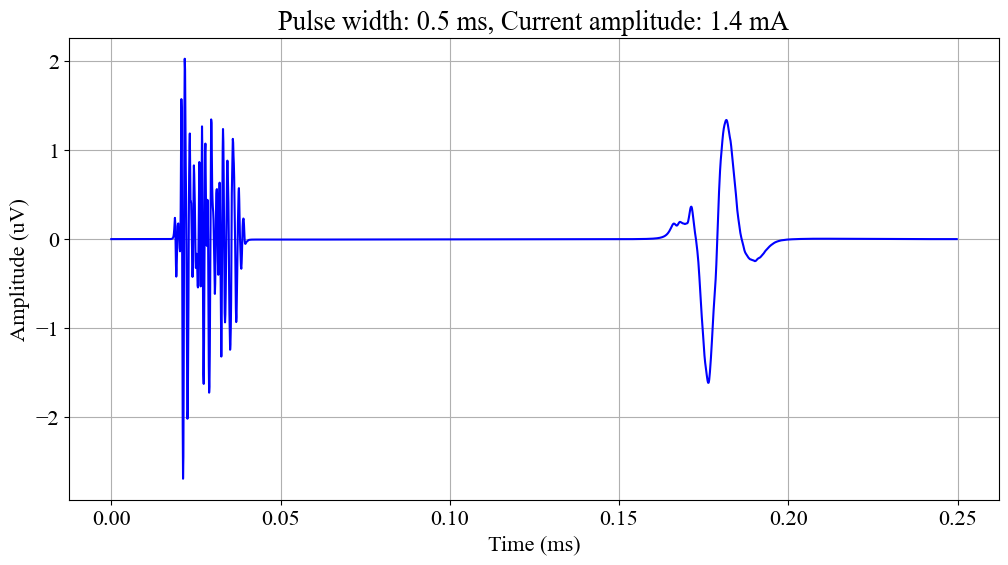

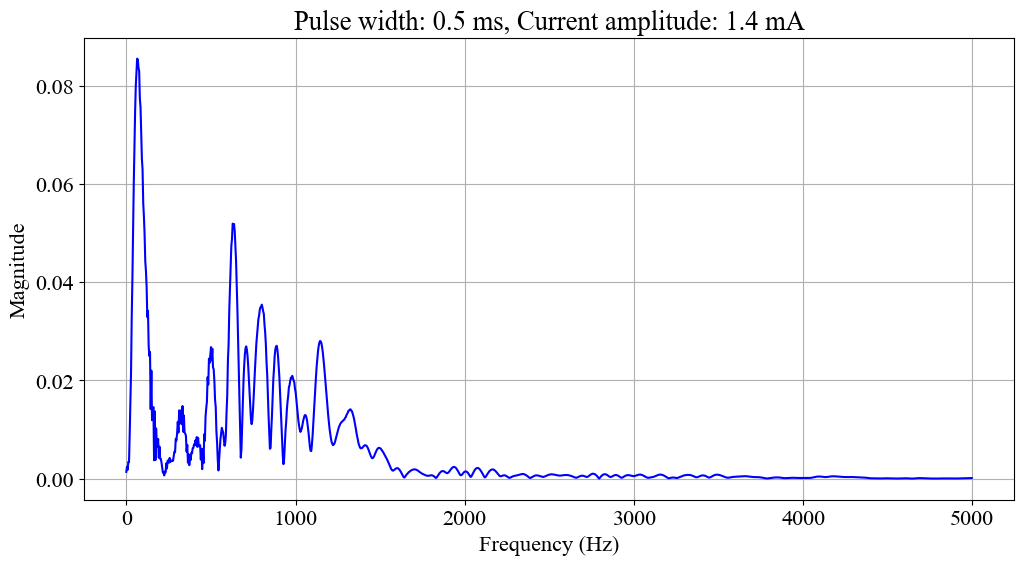

In [5]:
sid = 663

stimulus = stimulations[str(sid)]
response = responses[str(sid)]
sample_data = data.iloc[sid, :]
freq = sample_data['frequency']
print('Frequency: {} Hz'.format(freq))
pulse_width = sample_data['pulse_width']
stim_current = sample_data['amplitude']
Ts = sample_data['dt'] * 1e-3  # Sampling period in seconds
fs = 1/Ts # Sampling frequency in Hz

N = len(response)  # Number of samples
yf = np.fft.fft(response)
f = np.fft.fftfreq(N, 1/fs)[:N//2]  # Frequency bins

fc = 1/pulse_width  # Cutoff frequency of the filter

# Calculate single-sided amplitude spectrum
fft_response = 2.0 / N * np.abs(yf[:N//2])

plt.figure(figsize=(12, 6))
plt.plot(t_stim, response, c='b')
plt.title(f'Pulse width: {pulse_width} ms, Current amplitude: {stim_current} mA')
plt.xlabel('Time (ms)')
plt.ylabel('Amplitude (uV)')
plt.grid(True)
plt.savefig(f'./ascent_{pulse_width}_{stim_current}.png', dpi=300)
plt.savefig(f'./ascent_{pulse_width}_{stim_current}.eps', dpi=300, format='eps')
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(f, fft_response, c='b')
# plt.plot([fc, fc], [0, 0.2], 'r--')
plt.title(f'Pulse width: {pulse_width} ms, Current amplitude: {stim_current} mA')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.grid(True)
plt.savefig(f'./ascent_fft_{pulse_width}_{stim_current}.png', dpi=300)
plt.savefig(f'./ascent_fft_{pulse_width}_{stim_current}.eps', dpi=300, format='eps')
plt.show()

Frequency: 20 Hz


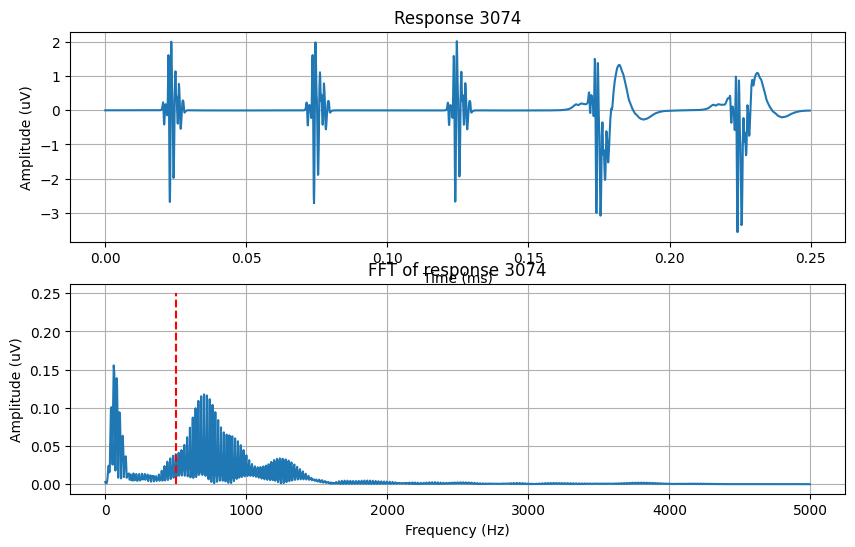

In [3]:
from scipy.signal import hilbert
from obspy.signal.filter import envelope

response = responses[str(sid)]
sample_data = data.iloc[sid, :]
freq = sample_data['frequency']
print('Frequency: {} Hz'.format(freq))
Ts = sample_data['dt'] * 1e-3  # Sampling period in seconds
fs = 1/Ts # Sampling frequency in Hz

N = len(response)  # Number of samples
yf = np.fft.fft(response)
f = np.fft.fftfreq(N, 1/fs)[:N//2]  # Frequency bins

# Calculate single-sided amplitude spectrum
fft_response = 2.0 / N * np.abs(yf[:N//2])

# Get envelope of the signal
fft_env = envelope(fft_response)

fig, ax = plt.subplots(2, 1, figsize=(10, 6))
ax[0].plot(t_resp, response)
ax[0].set_title('Response {}'.format(sid))
ax[0].set_xlabel('Time (ms)')
ax[0].set_ylabel('Amplitude (uV)')
ax[0].grid(True)

ax[1].plot(f, fft_response)
# ax[1].plot(f, fft_env)
ax[1].plot([fc, fc], [0, 0.25], 'r--')
ax[1].set_title('FFT of response {}'.format(sid))
ax[1].set_xlabel('Frequency (Hz)')
ax[1].set_ylabel('Amplitude (uV)')
ax[1].grid(True)


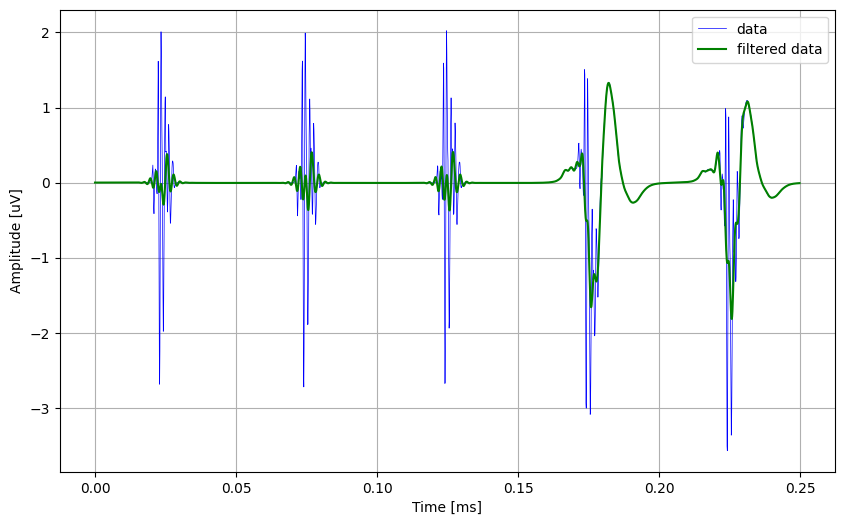

In [6]:
from scipy.signal import butter, lfilter, freqz, filtfilt, hilbert

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

# Filter requirements
order = 6
fs = 1/Ts  # sample rate, Hz
cutoff = 500 # desired cutoff frequency of the filter, Hz

# Get the filter coefficients so we can check its frequency response.
response_filt = butter_lowpass_filter(response, cutoff, fs, order)

plt.figure(figsize=(10, 6))
plt.plot(t_resp, response, 'b-', linewidth=0.5, label='data')
plt.plot(t_resp, response_filt, 'g-', label='filtered data')
plt.xlabel('Time [ms]')
plt.ylabel('Amplitude [uV]')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
def lowpass_filter(data, cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def remove_stim_artefacts(response, cutoff, fs, order=6):
    response_filt = lowpass_filter(response, cutoff, fs, order)
    return response_filt


for sid in responses.columns[1:]:
    response = responses[str(sid)]
    if np.all(stimulations[str(sid)] == 0):
        responses[str(sid)] = 0

# remove stimulation artefacts from all responses
Ts = data['dt'][0] * 1e-3  # Sampling period in seconds
fs = 1/Ts # Sampling frequency in Hz
cutoff = 250
filtered_responses = responses.copy()
for sid in responses.columns[1:]:
    response = responses[str(sid)]
    filtered_responses[str(sid)] = remove_stim_artefacts(response, cutoff, fs, order)


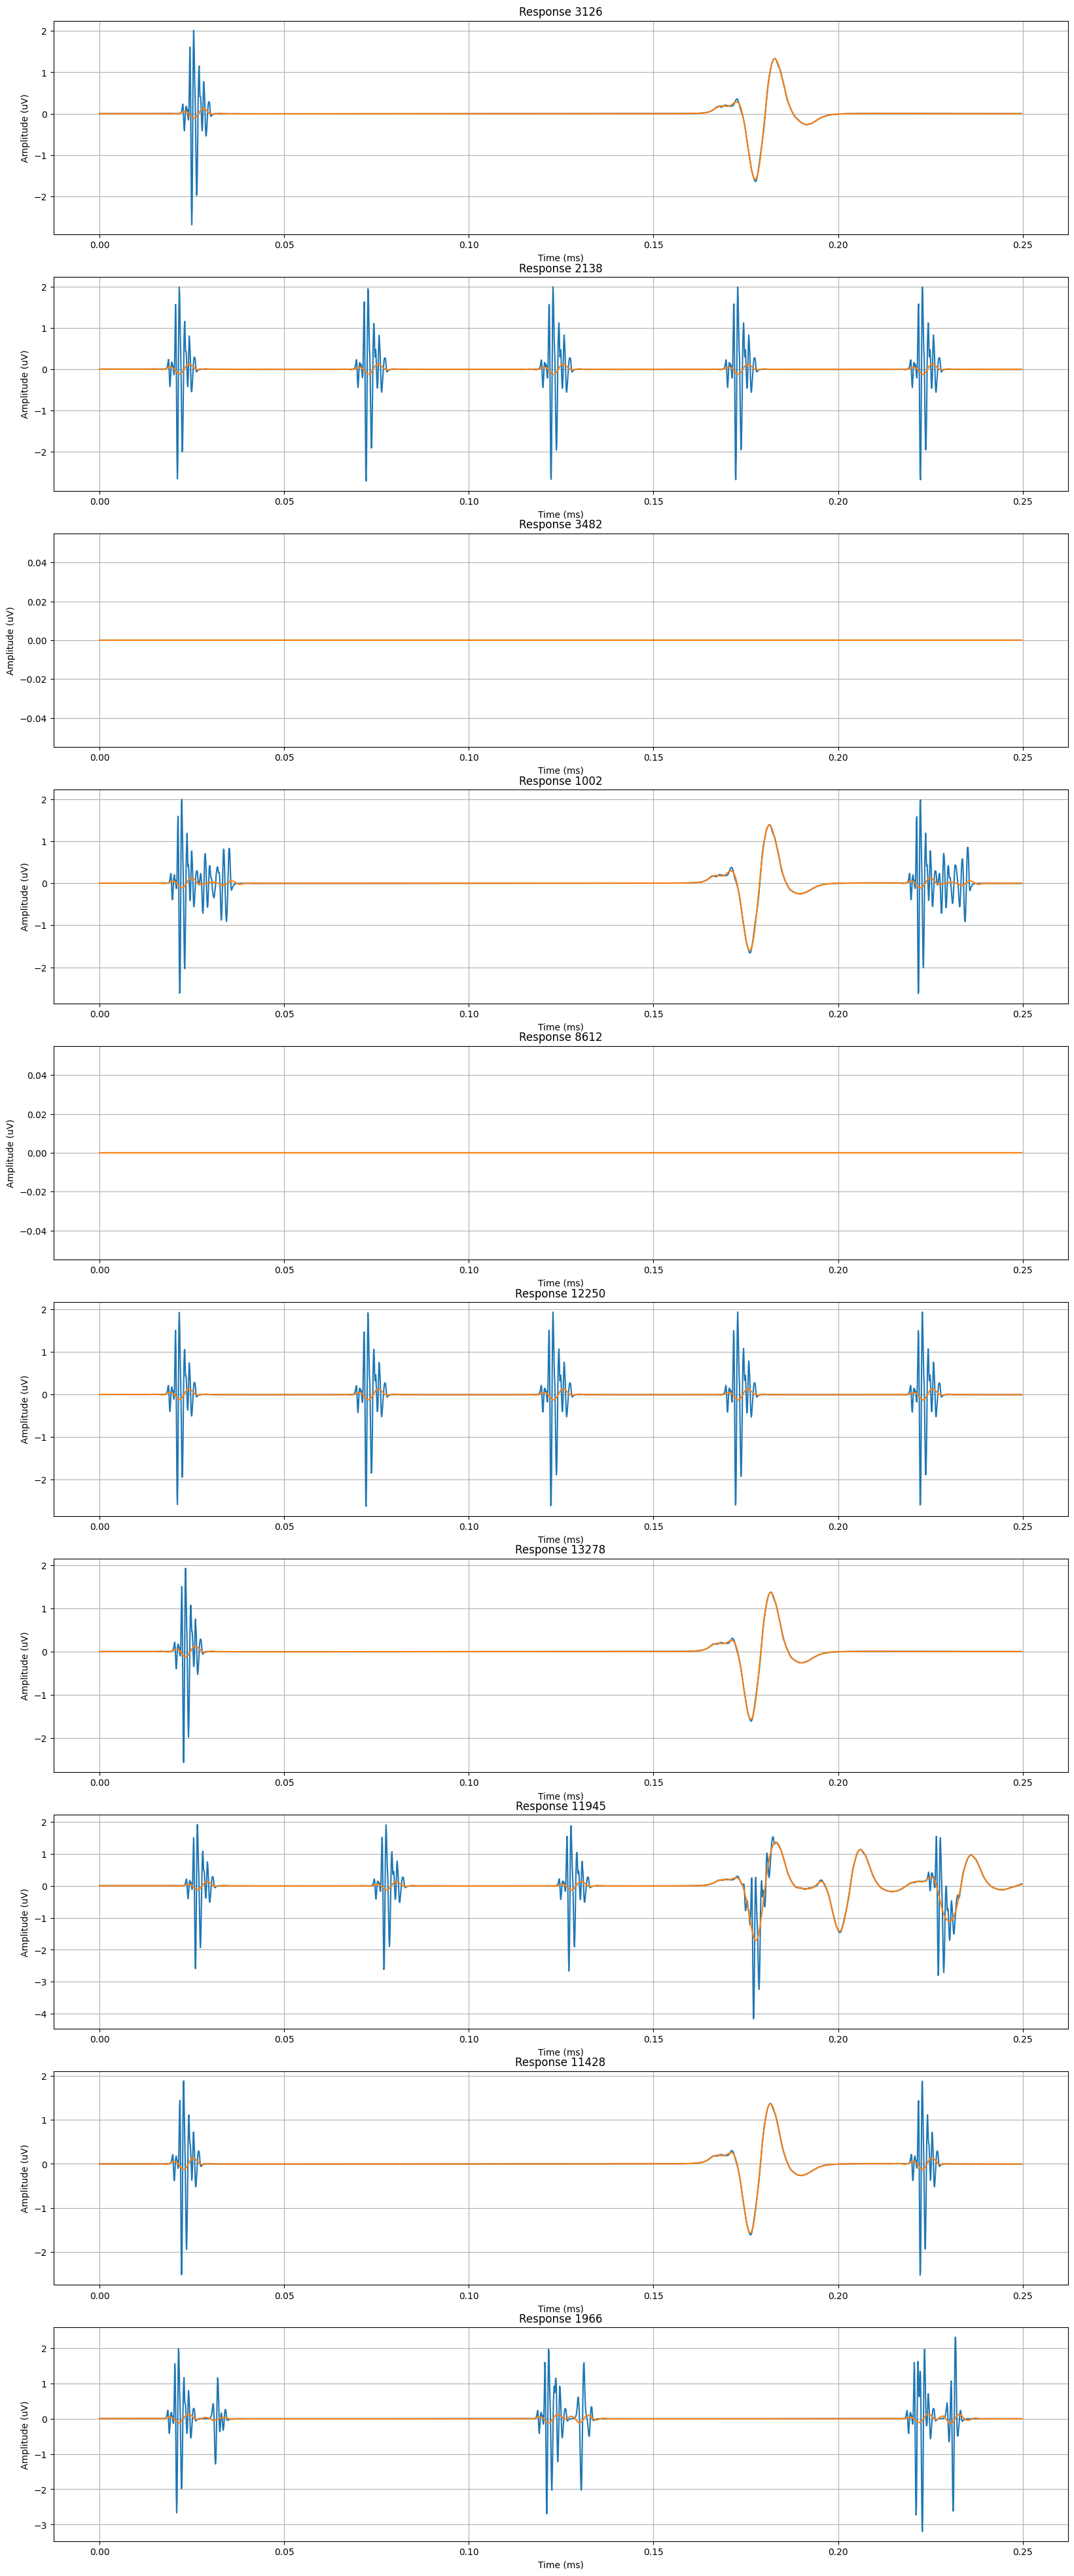

In [9]:

# Plot 10 random responses with the artefacts removed
random_id = np.random.randint(0, len(responses.columns)-1, 10)

fig, ax = plt.subplots(10, 1, figsize=(20, 50))

for i, id in enumerate(random_id):
    ax[i].plot(t_resp, responses[str(id)].values)
    ax[i].plot(t_resp, filtered_responses[str(id)].values)
    ax[i].set_title('Response {}'.format(id))
    ax[i].set_xlabel('Time (ms)')
    ax[i].set_ylabel('Amplitude (uV)')
    ax[i].grid(True)

In [10]:
# Save the filtered responses
filtered_responses.to_csv('../data/vns_responses_filtered.csv', index=False)